## Required Packages

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re

## Data Retrieval

https://docs.openreview.net/how-to-guides/data-retrieval-and-modification/how-to-get-all-submissions

In [2]:
import openreview

# API V2
client = openreview.api.OpenReviewClient(
    baseurl='https://api2.openreview.net',
    username='USERNAME',
    password='PASSWORD'
)
venues = client.get_group(id='venues').members
venue_neurips_conf = [venue for venue in venues if 'NeurIPS' in venue and 'Conference' in venue]
print(venue_neurips_conf)

['NeurIPS.cc/2020/Conference', 'NeurIPS.cc/2021/Conference', 'NeurIPS.cc/2022/Conference', 'NeurIPS.cc/2023/Conference', 'NeurIPS.cc/2024/Conference']


### 2023-2024

In [3]:
for venue in venue_neurips_conf[3:]:
# venue = 'NeurIPS.cc/2024/Conference'
    venue_group = client.get_group(venue)
    # submission_name = venue_group.content['submission_name']['value']
    
    submissions = client.get_all_notes(invitation=f'{venue}/-/Submission') # all submission
    # submissions = client.get_all_notes(content={'venueid':{venue}}) # all accept
    print(venue + ' Downloads Done!')
    
    # {key: submission_content.get(key).get('value') for key in submission_content.keys()}
    content_df = pd.DataFrame.from_dict([{key: submission.content.get(key).get('value') for key in submission.content.keys()} for submission in submissions])
    all_df = pd.DataFrame.from_dict([submission.to_json() for submission in submissions])
    all_df.drop(['content'], axis=1, inplace = True)
    all_df = pd.concat([all_df, content_df], axis=1)
    
    # all_df.head()
    file_name = venue.replace('.', '_').replace('/', '_') + '_submission.csv' # '_accept.csv'
    all_df.to_csv(file_name, index=False, encoding='utf-8')
    print(venue + ' Write to local Done!')

Getting V2 Notes: 100%|██████████████████▉| 3391/3395 [00:02<00:00, 1408.16it/s]


NeurIPS.cc/2023/Conference Downloads Done!
NeurIPS.cc/2023/Conference Write to local Done!


Getting V2 Notes: 100%|██████████████████▉| 4231/4236 [00:03<00:00, 1289.42it/s]


NeurIPS.cc/2024/Conference Downloads Done!
NeurIPS.cc/2024/Conference Write to local Done!


### 2021 - 2022

In [4]:
def get_conference_notes(venue, blind_submission=False):
    """
    Get all notes of a conference (data) from OpenReview API.
    If results are not final, you should set blind_submission=True.
    """

    blind_param = '-/Blind_Submission' if blind_submission else ''
    offset = 0
    notes = []
    while True:
        print('Offset:', offset, 'Data:', len(notes))
        url = f'https://api.openreview.net/notes?invitation={venue}/{blind_param}&offset={offset}'
        response = requests.get(url)
        data = response.json()
        if len(data['notes']) == 0:
            break
        offset += 1000
        notes.extend(data['notes'])
    return notes

for venue in venue_neurips_conf[1:3]: 
    raw_notes = get_conference_notes(venue, blind_submission=True)
    print(venue, "Number of submissions:", len(raw_notes))
    df_raw = pd.json_normalize(raw_notes)
    # all_df.head()
    file_name = venue.replace('.', '_').replace('/', '_') + '_submission.csv'
    df_raw.to_csv(file_name, index=False, encoding='utf-8')
    print(venue + ' Write to local Done!')

Offset: 0 Data: 0
Offset: 1000 Data: 1000
Offset: 2000 Data: 2000
Offset: 3000 Data: 2768
NeurIPS.cc/2021/Conference Number of submissions: 2768
NeurIPS.cc/2021/Conference Write to local Done!
Offset: 0 Data: 0
Offset: 1000 Data: 1000
Offset: 2000 Data: 2000
Offset: 3000 Data: 2824
NeurIPS.cc/2022/Conference Number of submissions: 2824
NeurIPS.cc/2022/Conference Write to local Done!


## Data Wrangling

In [3]:
df_date_keywords = pd.DataFrame()
    
replace_dict = {"(": "\',\'", ")": "\',\'", "”": "", "“": "",  
                "llm": "large language model", "llms": "large language model", 
                "models": "model", "networks": "network",
                "transformers": "transformer"
               }
def replace_multi(text, rep_dict):
    # use these three lines to do the replacement
    rep = dict((re.escape(k), v) for k, v in rep_dict.items()) 
    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    return(text)


for venue in venue_neurips_conf[1:]:
    file = venue.replace('.', '_').replace('/', '_') + '_submission.csv'
    df = pd.read_csv(file)
    tcdate_col = [col if col=='tcdate' else 'cdate' for col in df.columns]
    df['creation_date_time'] = pd.to_datetime(df[tcdate_col[0]], unit='ms')
    df['creation_date'] = df['creation_date_time'].dt.date
    df['year'] = df['creation_date_time'].dt.year
    keyword_col = [col for col in df.columns if 'keywords' in col]
    title_col = [col for col in df.columns if 'title' in col]
    df_copy = copy.deepcopy(df[title_col + keyword_col + ['creation_date', 'id', 'year']])
    col_map = {title_col[0]: 'title', keyword_col[0]: 'keyword'}
    df_copy.rename(columns = col_map, inplace=True)
    df_copy =df_copy.keyword.apply(
        lambda x: pd.Series([y.strip() for y in eval(replace_multi(x.lower(), replace_dict)) if y != ''])
    ) \
                    .merge(df_copy, right_index = True, left_index = True) \
                    .drop(['keyword'], axis = 1) \
                    .melt(id_vars = ['id', 'title', 'creation_date', 'year'], value_name = 'keyword') \
                    .dropna(axis=0) \
                    .reset_index() \
                    .drop(['index', 'variable'], axis=1)
    df_copy['venue'] = venue
    df_date_keywords = pd.concat([df_date_keywords, df_copy], axis=0)

df_date_keywords = df_date_keywords.sort_values(['year', 'venue', 'creation_date'], ascending=True, ignore_index=True)
df_date_keywords['count'] = df_date_keywords.groupby(['venue', 'year', 'keyword']).cumcount() + 1
df_year_keywords_agg = df_date_keywords.groupby(['venue', 'year', 'keyword']).agg({
    'count': 'max'
})
df_year_keywords_agg.reset_index(inplace=True)
df_year_keywords_pivot = df_year_keywords_agg.pivot(index='keyword',columns='year', values='count')
df_year_keywords_pivot= df_year_keywords_pivot.fillna(0)
df_year_keywords_pivot.to_csv('NeurIPS_year_keywords_2021_2024.csv', index=True)

In [4]:
df_year_keywords_agg = df_year_keywords_agg.sort_values(['year', 'count'], ascending=[True, False])
df_year_keywords_agg.reset_index(inplace=True)
df_year_keywords_agg['rank'] = df_year_keywords_agg.groupby('year')['count'].rank('dense').astype(int)
topn = 15
start_color = [217, 151, 217]# neurips downside half [125, 85, 148]
end_color = [113, 15, 113]# neurips upside half [85, 48, 120]
color_step = [(end_color[i] - start_color[i])/(topn-1) for i in range(len(start_color))]
topn_colors_rgb = [[int((start_color[j]+color_step[j]*i)) for j in range(len(start_color))] for i in range(topn)]

def rgb_to_hex(r, g, b):
    return(('{:02X}' * 3).format(r, g, b))

df_year_keywords_agg['rgb_color'] = df_year_keywords_agg['rank'].apply(lambda x: topn_colors_rgb[x] if x < topn else end_color)
df_year_keywords_agg['hex_color'] = df_year_keywords_agg['rgb_color'].apply(lambda x: rgb_to_hex(x[0], x[1], x[2]))
df_year_keywords_agg['keyword'] = df_year_keywords_agg['keyword'].apply(lambda x: x.title())

df_year_keywords_agg = df_year_keywords_agg.drop(['index'], axis=1)
df_year_keywords_agg.to_csv('NeurIPS_year_keywords_2021_2024_long.csv', index=True)

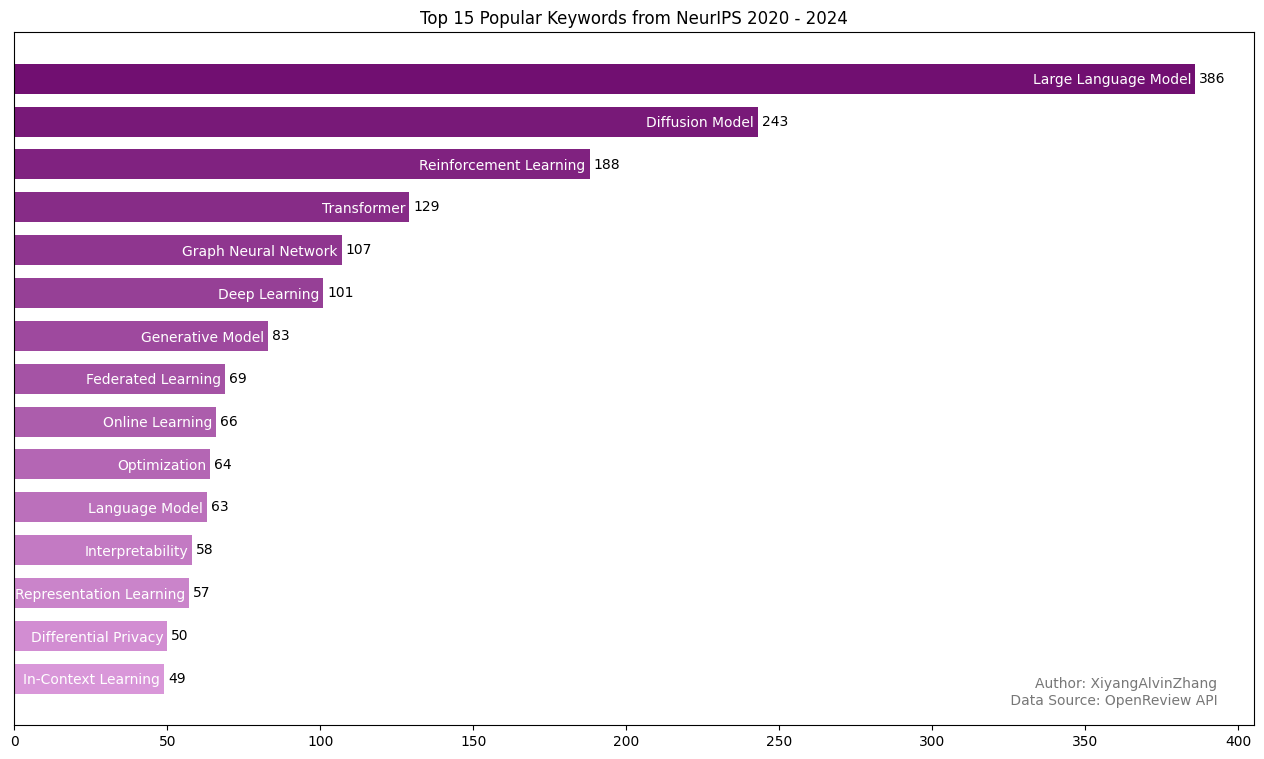

In [10]:
topn = 15
fig, ax = plt.subplots(figsize=(16,9))
years = df_year_keywords_pivot.columns
year = years[-1]

top_bars = df_year_keywords_pivot[year].sort_values(ascending=True).tail(topn)
start_color = [217, 151, 217]# neurips downside half [125, 85, 148]
end_color = [113, 15, 113]# neurips upside half [85, 48, 120]
color_step = [(end_color[i] - start_color[i])/(topn-1) for i in range(len(start_color))]

topn_colors = [[(start_color[j]+color_step[j]*i)/255 for j in range(len(start_color))] for i in range(topn)]

# ax.clear()

top_bars_index = [x.title() for x in top_bars.index]

ax.barh(top_bars_index, top_bars, color=topn_colors, height=0.7)
dx = top_bars.max() / 300
for i, (value, name) in enumerate(zip(list(top_bars), top_bars_index)):
    # Keywords
    ax.text(value-dx, i-0.2, name, color='white', ha='right', va='bottom')
    # Counts
    ax.text(value+dx, i, f'{value:,.0f}',color='black',ha='left',  va='center')

ax.set_title('Top ' + str(topn) + ' Popular Keywords from NeurIPS 2020 - 2024')
ax.text(0.97, 0.03, 'Author: XiyangAlvinZhang\n Data Source: OpenReview API',
        transform=ax.transAxes, ha='right', color='#777777',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.yticks([])
plt.show()

## Reference

- [OpenReview API - How to Get All Submissions](https://docs.openreview.net/how-to-guides/data-retrieval-and-modification/how-to-get-all-submissions)
- [fedebotu - ICLR2023-OpenReviewData](https://github.com/fedebotu/ICLR2023-OpenReviewData/tree/main)
- [Inovista Bar Race Chart for Tableau](https://www.inovista.com/animatorFiles/demoProjects/BarRaceTableau.html)